# 1D Flow Matching: Gap and Bump Experiments

This notebook explores how flow matching models handle challenging 1D distributions:
1. Gaussian with a gap (standard training)
2. Gaussian with a gap (focused training on high t values)
3. Uniform distribution with a small Gaussian bump

In [1]:
import flow_matching
import numpy as np
import torch
import matplotlib.pyplot as plt
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import ODESolver
from flow_matching.utils import ModelWrapper
import time
from torch import nn, Tensor

## Model Definition

In [2]:
# Activation class
class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor: 
        return torch.sigmoid(x) * x

# Model class
class MLP(nn.Module):
    def __init__(self, input_dim: int = 1, time_dim: int = 1, hidden_dim: int = 128, num_layers: int = 4):
        super().__init__()
        
        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim
        self.layer_norm = nn.LayerNorm(input_dim)

        self.main = nn.Sequential(
            nn.Linear(input_dim+time_dim, hidden_dim),
            Swish(),
            *[
                nn.Sequential(
                    nn.Linear(hidden_dim, hidden_dim),
                    Swish(),
                ) for _ in range(num_layers - 2)
            ],
            nn.Linear(hidden_dim, input_dim),
        )
    
    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        sz = x.size()
        x = x.reshape(-1, self.input_dim)
        # x = self.layer_norm(x)
        t = t.reshape(-1, self.time_dim).float()

        t = t.reshape(-1, 1).expand(x.shape[0], 1)
        h = torch.cat([x, t], dim=1)
        output = self.main(h)
        
        return output.reshape(*sz)

class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t, **extras)

## Distribution Setup

### Target: 1D Gaussian with Gap
### Source: Standard 1D Gaussian

In [3]:
# Target distribution: 1D Gaussian with a gap
expansion_factor = 1
mean_target = 10.0
std_target = 1.0
gap_start = 9.5 * expansion_factor
gap_end = 9.8 * expansion_factor

def sample_target_with_gap(n_samples):
    """Sample from 1D Gaussian excluding the gap region"""
    samples = torch.normal(mean_target, std_target, size=(n_samples * 2,)) * expansion_factor
    mask = (samples < gap_start) | (samples > gap_end)
    return samples[mask][:n_samples]

# Source distribution: Standard 1D Gaussian
source_dist = torch.distributions.Normal(0.0, 1.0)

# Generate samples for visualization
target_samples = sample_target_with_gap(100000)
source_samples = source_dist.sample((100000,))

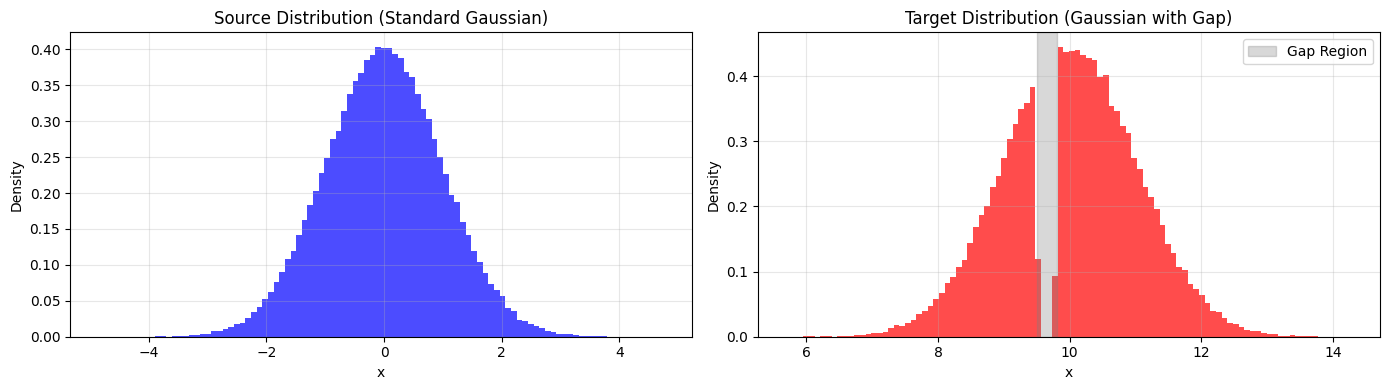

In [4]:
# Visualize source and target distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(source_samples.numpy(), bins=100, density=True, alpha=0.7, color='blue')
axes[0].set_title('Source Distribution (Standard Gaussian)', fontsize=12)
axes[0].set_xlabel('x')
axes[0].set_ylabel('Density')
axes[0].grid(alpha=0.3)

axes[1].hist(target_samples.numpy(), bins=100, density=True, alpha=0.7, color='red')
axes[1].axvspan(gap_start, gap_end, alpha=0.3, color='gray', label='Gap Region')
axes[1].set_title('Target Distribution (Gaussian with Gap)', fontsize=12)
axes[1].set_xlabel('x')
axes[1].set_ylabel('Density')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Experiment 1: Standard Training

In [4]:
# Training configuration
lr = 0.001
batch_size = 4096
iterations = 20001
print_every = 2000
hidden_dim = 512
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")

# Initialize model
vf1 = MLP(input_dim=1, time_dim=1, hidden_dim=hidden_dim).to(device)
path = AffineProbPath(scheduler=CondOTScheduler())
optim1 = torch.optim.Adam(vf1.parameters(), lr=lr)

# Training loop
losses_exp1 = []
start_time = time.time()

for i in range(iterations):
    optim1.zero_grad()
    
    # Sample data
    x_1 = sample_target_with_gap(batch_size).unsqueeze(1).to(device)
    x_0 = source_dist.sample((batch_size,)).unsqueeze(1).to(device)
    
    # Sample time uniformly
    t = torch.rand(batch_size).to(device)
    
    # Sample probability path
    path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
    out = vf1(path_sample.x_t, path_sample.t)
    
    # Flow matching loss
    loss = torch.pow(out - path_sample.dx_t, 2).mean()
    
    # Optimizer step
    loss.backward()
    optim1.step()
    
    losses_exp1.append(loss.item())
    
    # Log progress
    if (i + 1) % print_every == 0:
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f}'.format(
            i + 1, elapsed * 1000 / print_every, loss.item()))
        start_time = time.time()

print("\nExperiment 1 training complete!")

Using device: cuda


KeyboardInterrupt: 

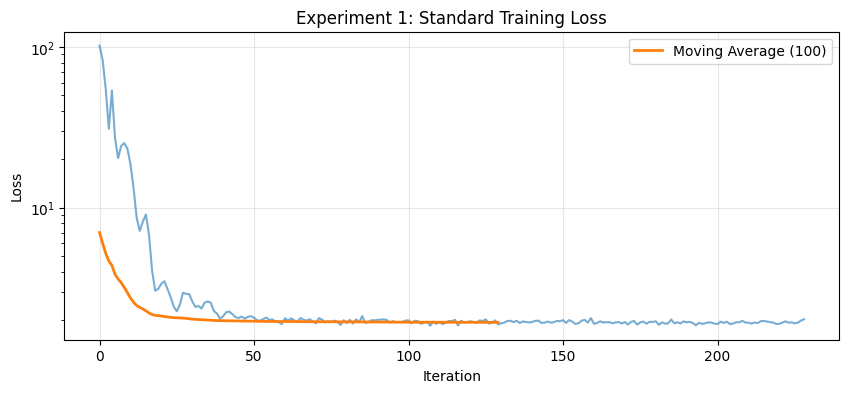

In [ ]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses_exp1, alpha=0.6)
plt.plot(np.convolve(losses_exp1, np.ones(100)/100, mode='valid'), linewidth=2, label='Moving Average (100)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Experiment 1: Standard Training Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.yscale('log')
plt.show()

### Generate Samples and Visualize Trajectories (Experiment 1)

In [ ]:
# Sample trajectories
wrapped_vf1 = WrappedModel(vf1)
solver1 = ODESolver(velocity_model=wrapped_vf1)

n_samples = 50000
n_trajectory_samples = 200  # Number of individual trajectories to plot
step_size = 0.05
T = torch.linspace(0, 1, 20).to(device)

x_init_exp1 = source_dist.sample((n_samples,)).unsqueeze(1).to(device)
sol_exp1 = solver1.sample(
    time_grid=T, 
    x_init=x_init_exp1, 
    method='midpoint', 
    step_size=step_size, 
    return_intermediates=True
)
sol_exp1 = sol_exp1.cpu().numpy().squeeze()

print(f"Generated trajectories shape: {sol_exp1.shape}")

Generated trajectories shape: (20, 50000)


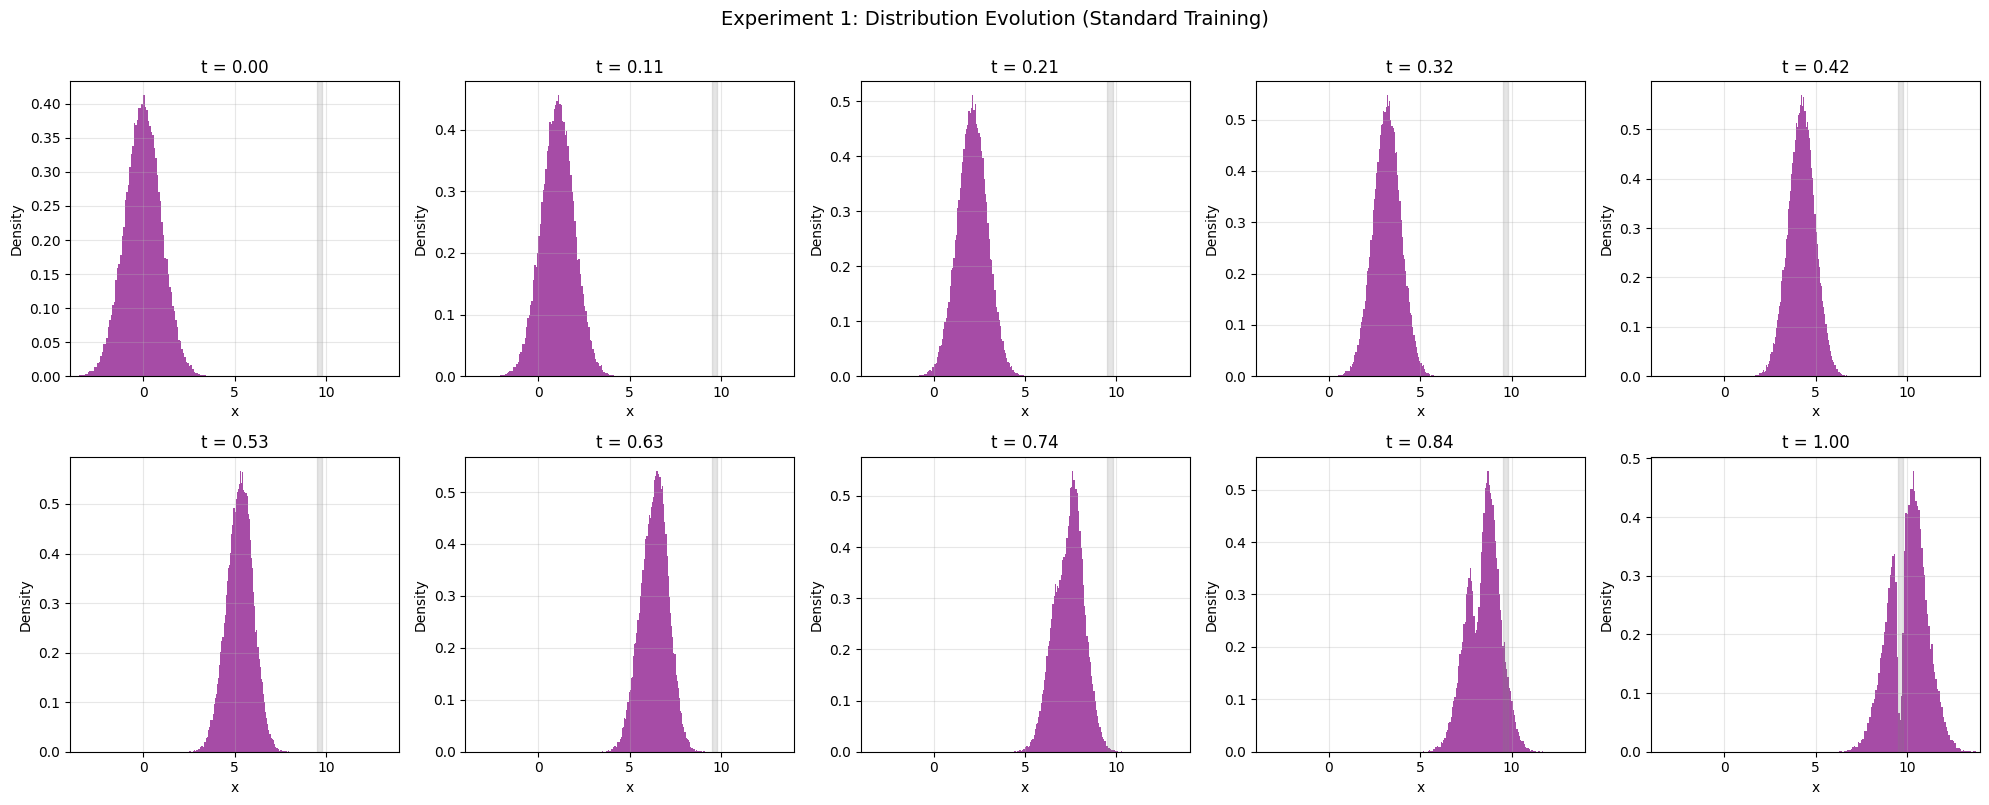

In [ ]:
# Visualize evolution over time
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

time_indices = np.linspace(0, len(T)-1, 10, dtype=int)

for idx, t_idx in enumerate(time_indices):
    axes[idx].hist(sol_exp1[t_idx], bins=100, density=True, alpha=0.7, color='purple')
    axes[idx].axvspan(gap_start, gap_end, alpha=0.2, color='gray')
    axes[idx].set_title(f't = {T[t_idx].cpu().item():.2f}')
    axes[idx].set_xlabel('x')
    axes[idx].set_ylabel('Density')
    axes[idx].grid(alpha=0.3)
    axes[idx].set_xlim(-4, 14)

plt.suptitle('Experiment 1: Distribution Evolution (Standard Training)', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

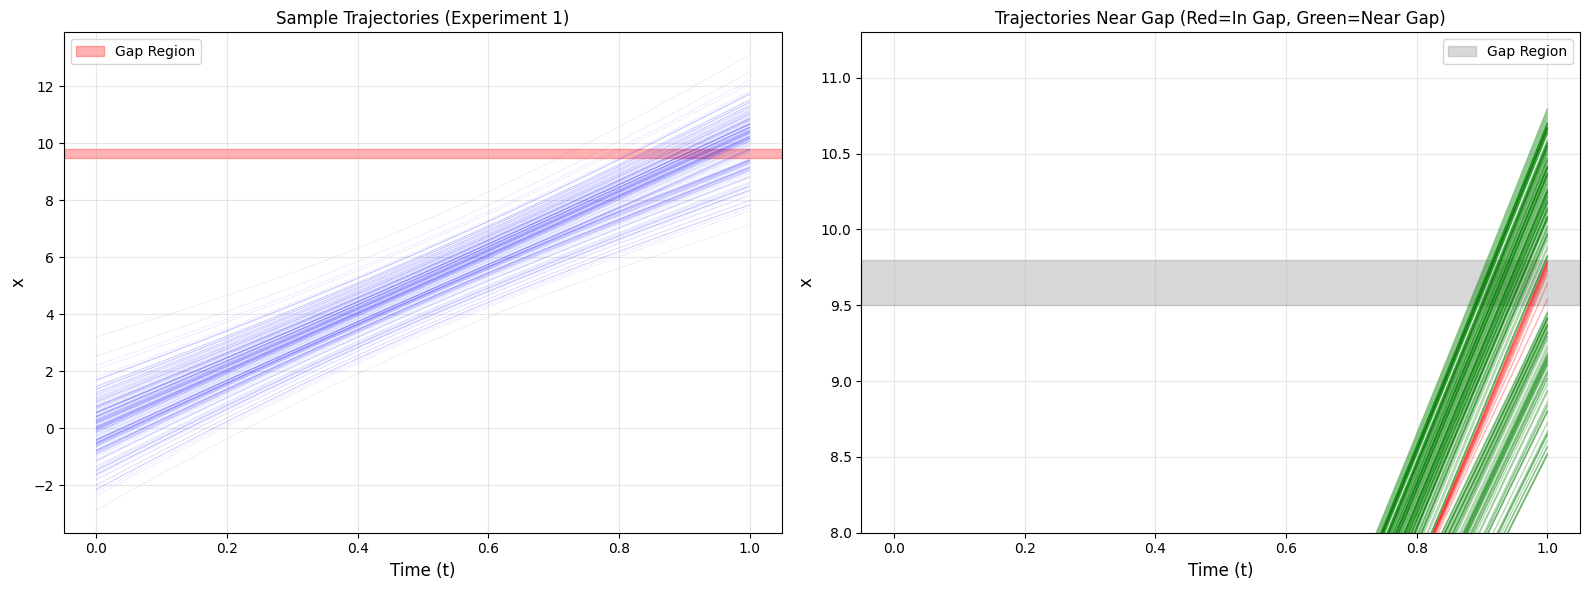

Points ending in gap region: 1310 (2.62%)


In [ ]:
# Visualize individual trajectories, focusing on gap region
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot all trajectories (subset for clarity)
for i in range(min(n_trajectory_samples, n_samples)):
    axes[0].plot(T.cpu().numpy(), sol_exp1[:, i], alpha=0.1, color='blue', linewidth=0.5)

axes[0].axhspan(gap_start, gap_end, alpha=0.3, color='red', label='Gap Region')
axes[0].set_xlabel('Time (t)', fontsize=12)
axes[0].set_ylabel('x', fontsize=12)
axes[0].set_title('Sample Trajectories (Experiment 1)', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Focus on trajectories near the gap
final_positions = sol_exp1[-1, :]
near_gap_mask = (final_positions >= gap_start - 1.0) & (final_positions <= gap_end + 1.0)
near_gap_indices = np.where(near_gap_mask)[0][:n_trajectory_samples]

for i in near_gap_indices:
    color = 'red' if gap_start <= final_positions[i] <= gap_end else 'green'
    axes[1].plot(T.cpu().numpy(), sol_exp1[:, i], alpha=0.3, color=color, linewidth=1.0)

axes[1].axhspan(gap_start, gap_end, alpha=0.3, color='gray', label='Gap Region')
axes[1].set_xlabel('Time (t)', fontsize=12)
axes[1].set_ylabel('x', fontsize=12)
axes[1].set_title('Trajectories Near Gap (Red=In Gap, Green=Near Gap)', fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)
axes[1].set_ylim(gap_start - 1.5, gap_end + 1.5)

plt.tight_layout()
plt.show()

# Count points in gap
points_in_gap = np.sum((final_positions >= gap_start) & (final_positions <= gap_end))
print(f"Points ending in gap region: {points_in_gap} ({100*points_in_gap/n_samples:.2f}%)")

## Experiment 2: Focused Training on High t Values (t > 0.75)

This experiment oversamples time points near t=1 to force the model to focus more on the final distribution structure.

In [ ]:
# Initialize new model
vf2 = MLP(input_dim=1, time_dim=1, hidden_dim=hidden_dim).to(device)
optim2 = torch.optim.Adam(vf2.parameters(), lr=lr)

# Training loop with biased time sampling
losses_exp2 = []
start_time = time.time()
high_t_threshold = 0.75
high_t_oversample_ratio = 5  # Train 5x more on high t values

for i in range(iterations):
    optim2.zero_grad()
    
    # Sample data
    x_1 = sample_target_with_gap(batch_size).unsqueeze(1).to(device)
    x_0 = source_dist.sample((batch_size,)).unsqueeze(1).to(device)
    
    # Biased time sampling: oversample t > 0.75
    if np.random.rand() < high_t_oversample_ratio / (1 + high_t_oversample_ratio):
        # Sample from [0.75, 1.0]
        t = torch.rand(batch_size).to(device) * 0.25 + 0.75
    else:
        # Sample uniformly from [0, 1]
        t = torch.rand(batch_size).to(device)
    
    # Sample probability path
    path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
    out = vf2(path_sample.x_t, path_sample.t)
    
    # Flow matching loss
    loss = torch.pow(out - path_sample.dx_t, 2).mean()
    
    # Optimizer step
    loss.backward()
    optim2.step()
    
    losses_exp2.append(loss.item())
    
    # Log progress
    if (i + 1) % print_every == 0:
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f}'.format(
            i + 1, elapsed * 1000 / print_every, loss.item()))
        start_time = time.time()

print("\nExperiment 2 training complete!")

| iter   2000 |  4.91 ms/step | loss    1.290
| iter   4000 |  4.96 ms/step | loss    1.318
| iter   6000 |  4.95 ms/step | loss    1.253
| iter   8000 |  4.96 ms/step | loss    1.338
| iter  10000 |  4.95 ms/step | loss    1.305
| iter  12000 |  4.95 ms/step | loss    1.306
| iter  14000 |  4.95 ms/step | loss    1.303
| iter  16000 |  4.95 ms/step | loss    1.309
| iter  18000 |  4.96 ms/step | loss    1.283
| iter  20000 |  4.96 ms/step | loss    1.280

Experiment 2 training complete!


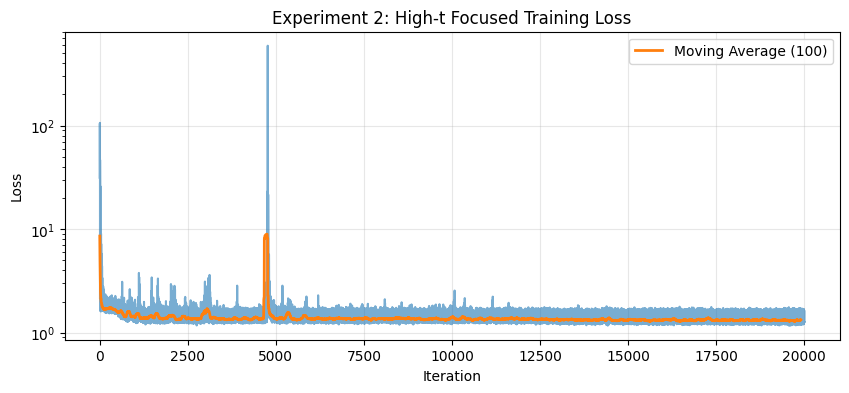

In [ ]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses_exp2, alpha=0.6)
plt.plot(np.convolve(losses_exp2, np.ones(100)/100, mode='valid'), linewidth=2, label='Moving Average (100)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Experiment 2: High-t Focused Training Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.yscale('log')
plt.show()

### Generate Samples and Visualize Trajectories (Experiment 2)

In [ ]:
# Sample trajectories
wrapped_vf2 = WrappedModel(vf2)
solver2 = ODESolver(velocity_model=wrapped_vf2)

x_init_exp2 = source_dist.sample((n_samples,)).unsqueeze(1).to(device)
sol_exp2 = solver2.sample(
    time_grid=T, 
    x_init=x_init_exp2, 
    method='midpoint', 
    step_size=step_size, 
    return_intermediates=True
)
sol_exp2 = sol_exp2.cpu().numpy().squeeze()

print(f"Generated trajectories shape: {sol_exp2.shape}")

Generated trajectories shape: (20, 50000)


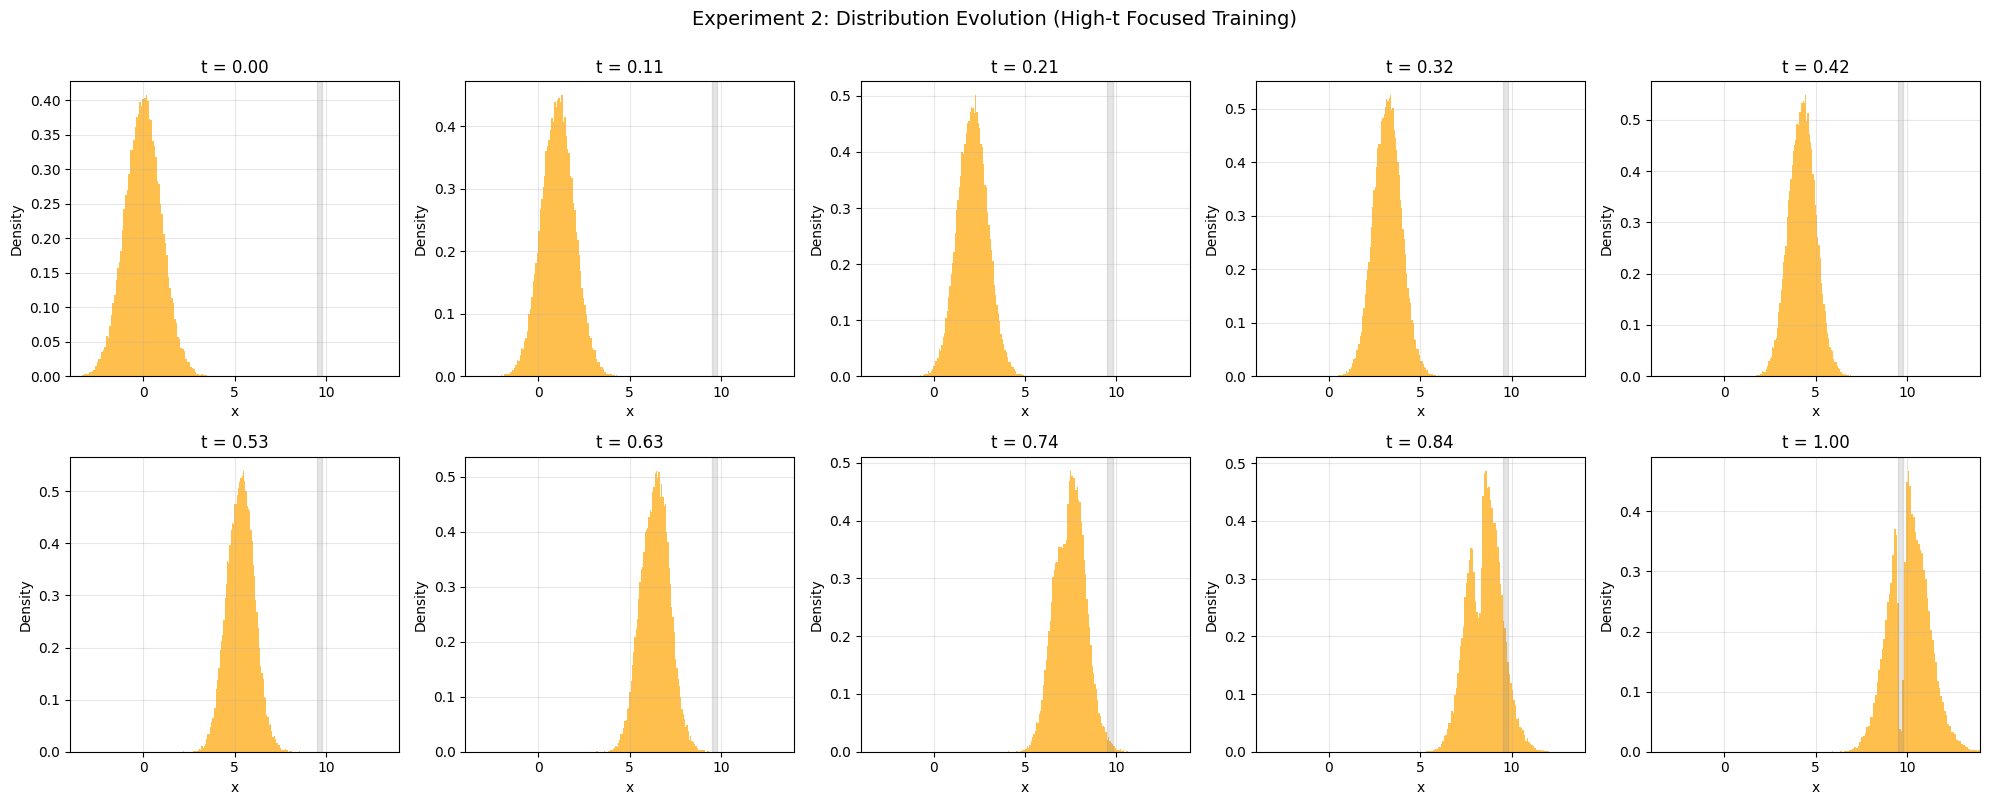

In [ ]:
# Visualize evolution over time
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, t_idx in enumerate(time_indices):
    axes[idx].hist(sol_exp2[t_idx], bins=100, density=True, alpha=0.7, color='orange')
    axes[idx].axvspan(gap_start, gap_end, alpha=0.2, color='gray')
    axes[idx].set_title(f't = {T[t_idx].cpu().item():.2f}')
    axes[idx].set_xlabel('x')
    axes[idx].set_ylabel('Density')
    axes[idx].grid(alpha=0.3)
    axes[idx].set_xlim(-4, 14)

plt.suptitle('Experiment 2: Distribution Evolution (High-t Focused Training)', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

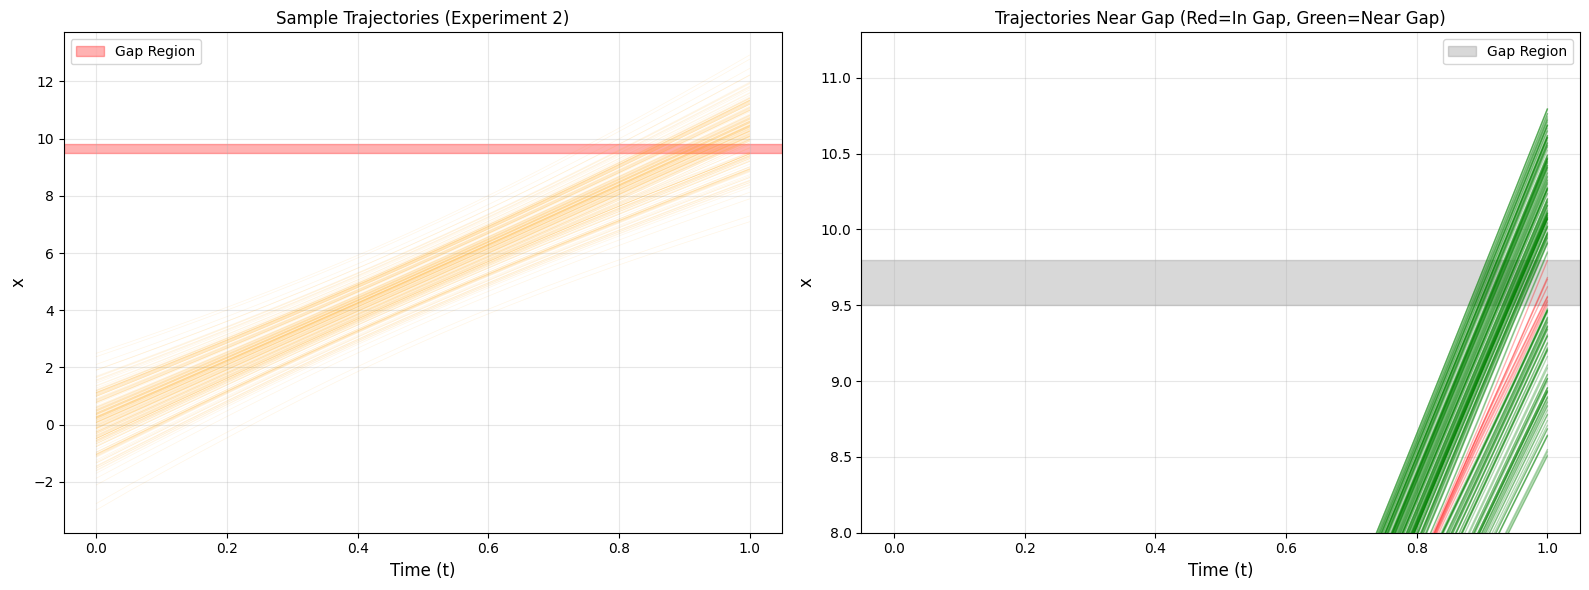

Points ending in gap region: 1207 (2.41%)


In [ ]:
# Visualize individual trajectories
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot all trajectories
for i in range(min(n_trajectory_samples, n_samples)):
    axes[0].plot(T.cpu().numpy(), sol_exp2[:, i], alpha=0.1, color='orange', linewidth=0.5)

axes[0].axhspan(gap_start, gap_end, alpha=0.3, color='red', label='Gap Region')
axes[0].set_xlabel('Time (t)', fontsize=12)
axes[0].set_ylabel('x', fontsize=12)
axes[0].set_title('Sample Trajectories (Experiment 2)', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Focus on trajectories near the gap
final_positions_exp2 = sol_exp2[-1, :]
near_gap_mask_exp2 = (final_positions_exp2 >= gap_start - 1.0) & (final_positions_exp2 <= gap_end + 1.0)
near_gap_indices_exp2 = np.where(near_gap_mask_exp2)[0][:n_trajectory_samples]

for i in near_gap_indices_exp2:
    color = 'red' if gap_start <= final_positions_exp2[i] <= gap_end else 'green'
    axes[1].plot(T.cpu().numpy(), sol_exp2[:, i], alpha=0.3, color=color, linewidth=1.0)

axes[1].axhspan(gap_start, gap_end, alpha=0.3, color='gray', label='Gap Region')
axes[1].set_xlabel('Time (t)', fontsize=12)
axes[1].set_ylabel('x', fontsize=12)
axes[1].set_title('Trajectories Near Gap (Red=In Gap, Green=Near Gap)', fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)
axes[1].set_ylim(gap_start - 1.5, gap_end + 1.5)

plt.tight_layout()
plt.show()

# Count points in gap
points_in_gap_exp2 = np.sum((final_positions_exp2 >= gap_start) & (final_positions_exp2 <= gap_end))
print(f"Points ending in gap region: {points_in_gap_exp2} ({100*points_in_gap_exp2/n_samples:.2f}%)")

## Comparison: Experiment 1 vs Experiment 2

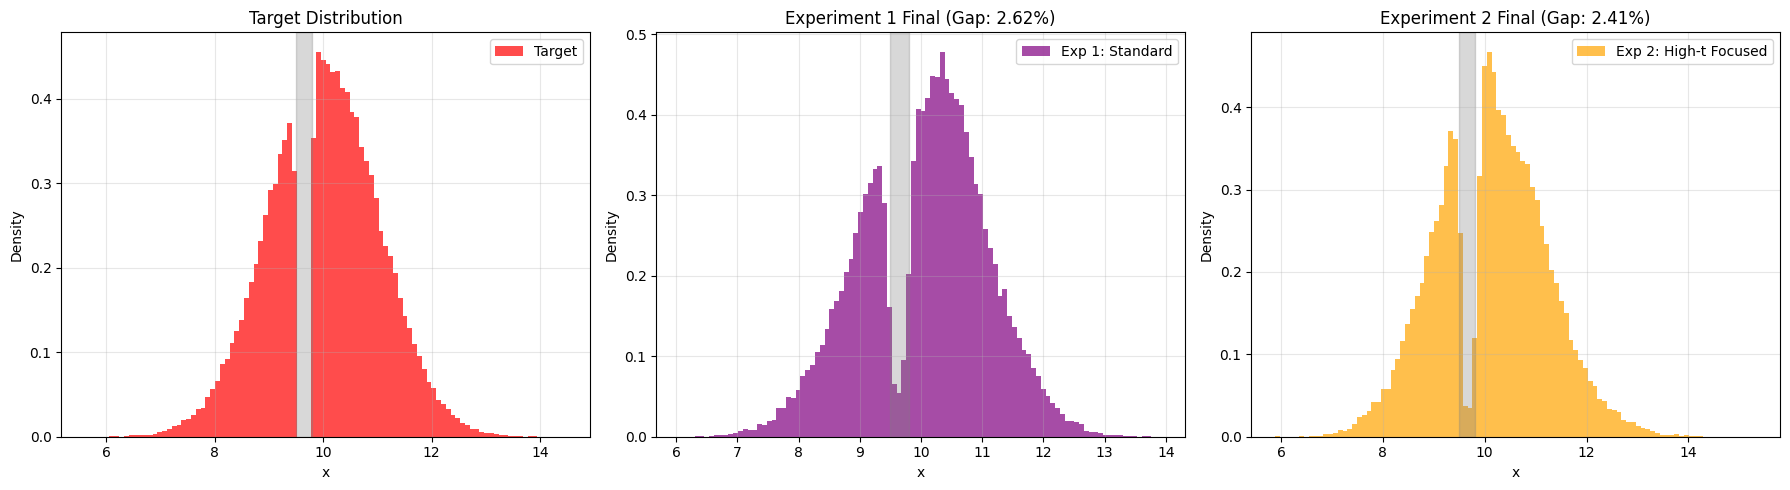

In [ ]:
# Compare final distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Target
axes[0].hist(target_samples.numpy(), bins=100, density=True, alpha=0.7, color='red', label='Target')
axes[0].axvspan(gap_start, gap_end, alpha=0.3, color='gray')
axes[0].set_title('Target Distribution', fontsize=12)
axes[0].set_xlabel('x')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Experiment 1
axes[1].hist(sol_exp1[-1], bins=100, density=True, alpha=0.7, color='purple', label='Exp 1: Standard')
axes[1].axvspan(gap_start, gap_end, alpha=0.3, color='gray')
axes[1].set_title(f'Experiment 1 Final (Gap: {100*points_in_gap/n_samples:.2f}%)', fontsize=12)
axes[1].set_xlabel('x')
axes[1].set_ylabel('Density')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Experiment 2
axes[2].hist(sol_exp2[-1], bins=100, density=True, alpha=0.7, color='orange', label='Exp 2: High-t Focused')
axes[2].axvspan(gap_start, gap_end, alpha=0.3, color='gray')
axes[2].set_title(f'Experiment 2 Final (Gap: {100*points_in_gap_exp2/n_samples:.2f}%)', fontsize=12)
axes[2].set_xlabel('x')
axes[2].set_ylabel('Density')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Experiment 3: Uniform Distribution with Small Gaussian Bump

Target: Uniform distribution [8, 12] with a small Gaussian bump at x=10

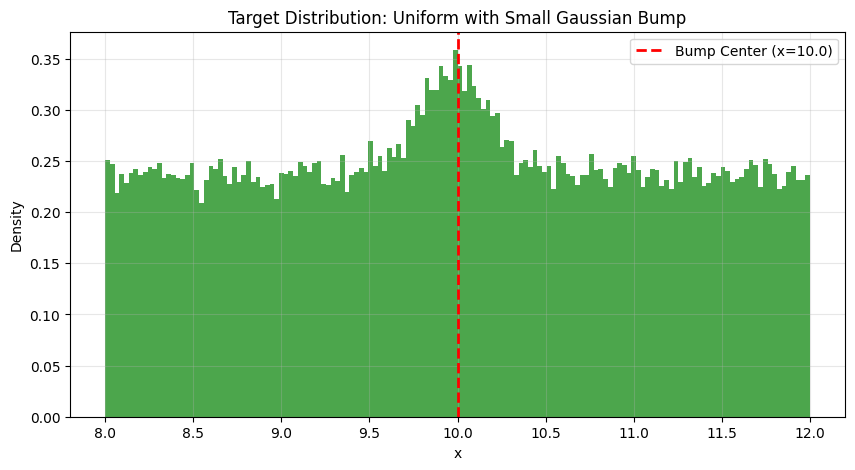

In [ ]:
# Define new target distribution
uniform_low = 8.0
uniform_high = 12.0
bump_mean = 10.0
bump_std = 0.2
bump_weight = 0.05  # 5% of total mass in the bump

def sample_uniform_with_bump(n_samples):
    """Sample from uniform + small Gaussian bump mixture"""
    n_bump = int(n_samples * bump_weight)
    n_uniform = n_samples - n_bump
    
    uniform_samples = torch.rand(n_uniform) * (uniform_high - uniform_low) + uniform_low
    bump_samples = torch.normal(bump_mean, bump_std, size=(n_bump,))
    
    # Filter bump samples to be within uniform range
    bump_samples = bump_samples[(bump_samples >= uniform_low) & (bump_samples <= uniform_high)]
    
    all_samples = torch.cat([uniform_samples, bump_samples])
    return all_samples[torch.randperm(len(all_samples))][:n_samples]

# Generate samples for visualization
target_samples_exp3 = sample_uniform_with_bump(100000)

# Visualize
plt.figure(figsize=(10, 5))
plt.hist(target_samples_exp3.numpy(), bins=150, density=True, alpha=0.7, color='green')
plt.axvline(bump_mean, color='red', linestyle='--', linewidth=2, label=f'Bump Center (x={bump_mean})')
plt.title('Target Distribution: Uniform with Small Gaussian Bump', fontsize=12)
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Initialize new model
vf3 = MLP(input_dim=1, time_dim=1, hidden_dim=hidden_dim).to(device)
optim3 = torch.optim.Adam(vf3.parameters(), lr=lr)

# Training loop
losses_exp3 = []
start_time = time.time()

for i in range(iterations):
    optim3.zero_grad()
    
    # Sample data
    x_1 = sample_uniform_with_bump(batch_size).unsqueeze(1).to(device)
    x_0 = source_dist.sample((batch_size,)).unsqueeze(1).to(device)
    
    # Sample time uniformly
    t = torch.rand(batch_size).to(device)
    
    # Sample probability path
    path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
    out = vf3(path_sample.x_t, path_sample.t)
    
    # Flow matching loss
    loss = torch.pow(out - path_sample.dx_t, 2).mean()
    
    # Optimizer step
    loss.backward()
    optim3.step()
    
    losses_exp3.append(loss.item())
    
    # Log progress
    if (i + 1) % print_every == 0:
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f}'.format(
            i + 1, elapsed * 1000 / print_every, loss.item()))
        start_time = time.time()

print("\nExperiment 3 training complete!")

| iter   2000 |  4.85 ms/step | loss    1.826
| iter   4000 |  4.85 ms/step | loss    1.683
| iter   6000 |  4.85 ms/step | loss    1.793
| iter   8000 |  4.85 ms/step | loss    1.708
| iter  10000 |  4.87 ms/step | loss    1.784
| iter  12000 |  4.86 ms/step | loss    1.692
| iter  14000 |  4.86 ms/step | loss    1.730
| iter  16000 |  4.85 ms/step | loss    1.794
| iter  18000 |  4.85 ms/step | loss    1.716
| iter  20000 |  4.85 ms/step | loss    1.705

Experiment 3 training complete!


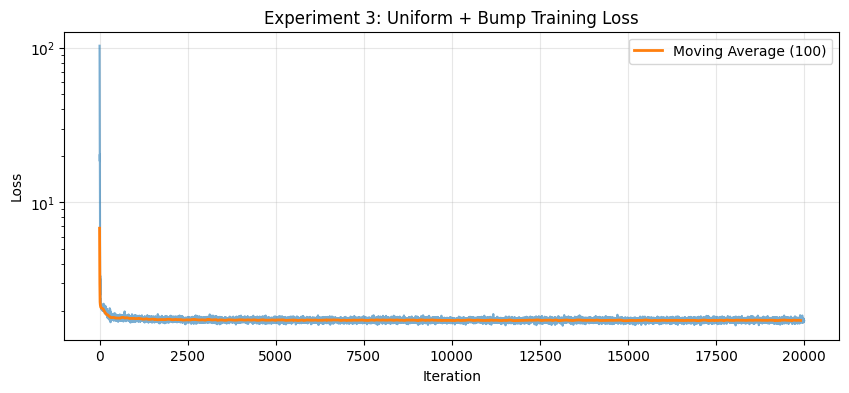

In [ ]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses_exp3, alpha=0.6)
plt.plot(np.convolve(losses_exp3, np.ones(100)/100, mode='valid'), linewidth=2, label='Moving Average (100)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Experiment 3: Uniform + Bump Training Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.yscale('log')
plt.show()

### Generate Samples and Visualize Trajectories (Experiment 3)

In [ ]:
# Sample trajectories
wrapped_vf3 = WrappedModel(vf3)
solver3 = ODESolver(velocity_model=wrapped_vf3)

x_init_exp3 = source_dist.sample((n_samples,)).unsqueeze(1).to(device)
sol_exp3 = solver3.sample(
    time_grid=T, 
    x_init=x_init_exp3, 
    method='midpoint', 
    step_size=step_size, 
    return_intermediates=True
)
sol_exp3 = sol_exp3.cpu().numpy().squeeze()

print(f"Generated trajectories shape: {sol_exp3.shape}")

Generated trajectories shape: (20, 50000)


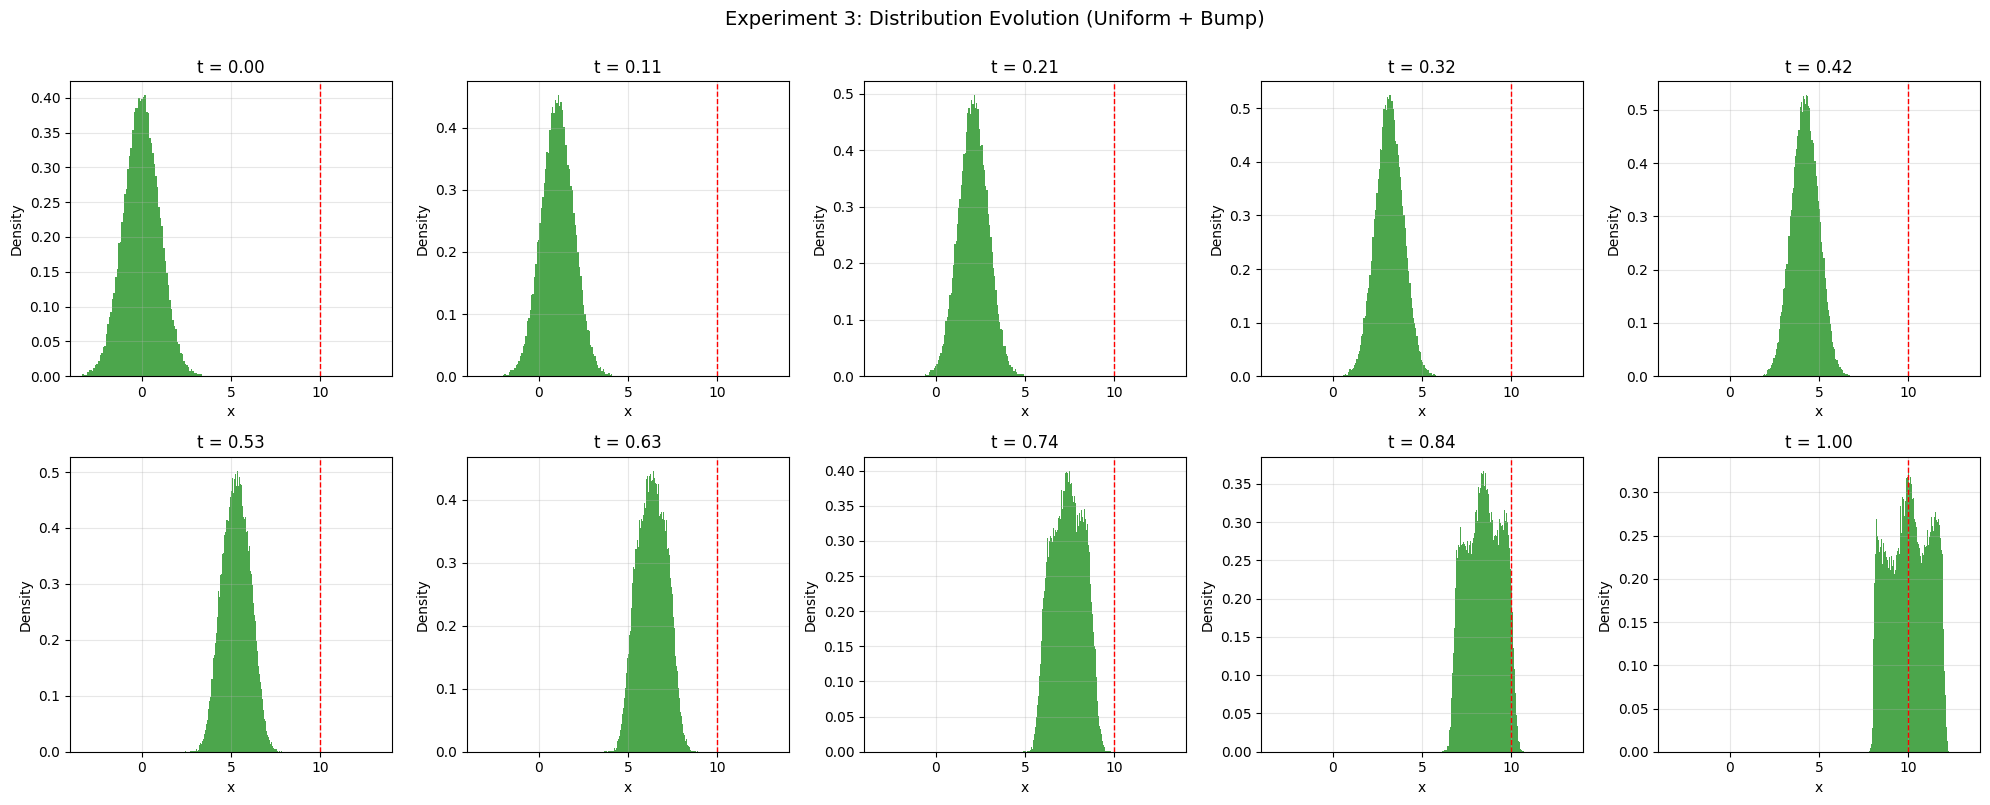

In [ ]:
# Visualize evolution over time
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, t_idx in enumerate(time_indices):
    axes[idx].hist(sol_exp3[t_idx], bins=100, density=True, alpha=0.7, color='green')
    axes[idx].axvline(bump_mean, color='red', linestyle='--', linewidth=1)
    axes[idx].set_title(f't = {T[t_idx].cpu().item():.2f}')
    axes[idx].set_xlabel('x')
    axes[idx].set_ylabel('Density')
    axes[idx].grid(alpha=0.3)
    axes[idx].set_xlim(-4, 14)

plt.suptitle('Experiment 3: Distribution Evolution (Uniform + Bump)', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

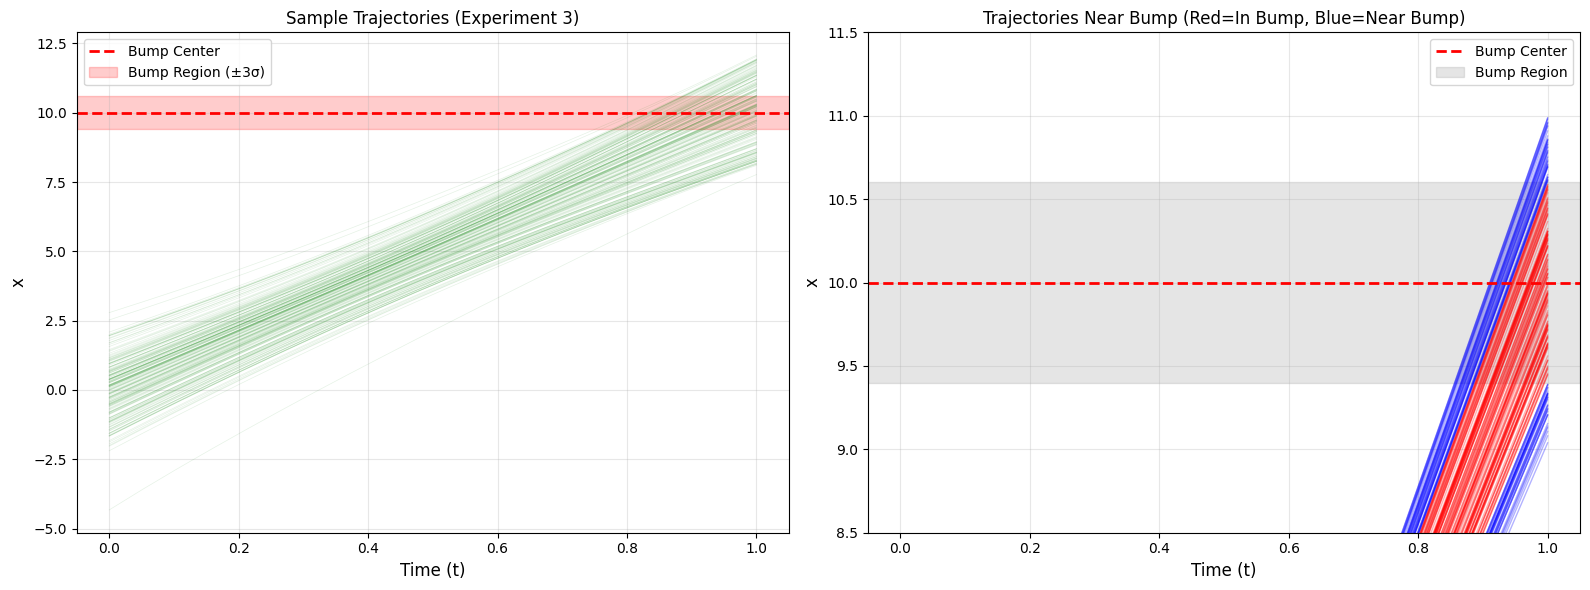

Points ending in bump region: 16844 (33.69%)
Expected based on target distribution: ~5.0%


In [ ]:
# Visualize individual trajectories focusing on bump region
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot all trajectories
for i in range(min(n_trajectory_samples, n_samples)):
    axes[0].plot(T.cpu().numpy(), sol_exp3[:, i], alpha=0.1, color='green', linewidth=0.5)

axes[0].axhline(bump_mean, color='red', linestyle='--', linewidth=2, label='Bump Center')
axes[0].axhspan(bump_mean - 3*bump_std, bump_mean + 3*bump_std, alpha=0.2, color='red', label='Bump Region (±3σ)')
axes[0].set_xlabel('Time (t)', fontsize=12)
axes[0].set_ylabel('x', fontsize=12)
axes[0].set_title('Sample Trajectories (Experiment 3)', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Focus on trajectories near the bump
final_positions_exp3 = sol_exp3[-1, :]
bump_region = 3 * bump_std
near_bump_mask = (final_positions_exp3 >= bump_mean - 1.0) & (final_positions_exp3 <= bump_mean + 1.0)
near_bump_indices = np.where(near_bump_mask)[0][:n_trajectory_samples]

for i in near_bump_indices:
    color = 'red' if abs(final_positions_exp3[i] - bump_mean) < bump_region else 'blue'
    axes[1].plot(T.cpu().numpy(), sol_exp3[:, i], alpha=0.3, color=color, linewidth=1.0)

axes[1].axhline(bump_mean, color='red', linestyle='--', linewidth=2, label='Bump Center')
axes[1].axhspan(bump_mean - bump_region, bump_mean + bump_region, alpha=0.2, color='gray', label='Bump Region')
axes[1].set_xlabel('Time (t)', fontsize=12)
axes[1].set_ylabel('x', fontsize=12)
axes[1].set_title('Trajectories Near Bump (Red=In Bump, Blue=Near Bump)', fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)
axes[1].set_ylim(bump_mean - 1.5, bump_mean + 1.5)

plt.tight_layout()
plt.show()

# Count points in bump region
points_in_bump = np.sum(np.abs(final_positions_exp3 - bump_mean) < bump_region)
print(f"Points ending in bump region: {points_in_bump} ({100*points_in_bump/n_samples:.2f}%)")
print(f"Expected based on target distribution: ~{bump_weight*100:.1f}%")

## Final Comparison: All Experiments

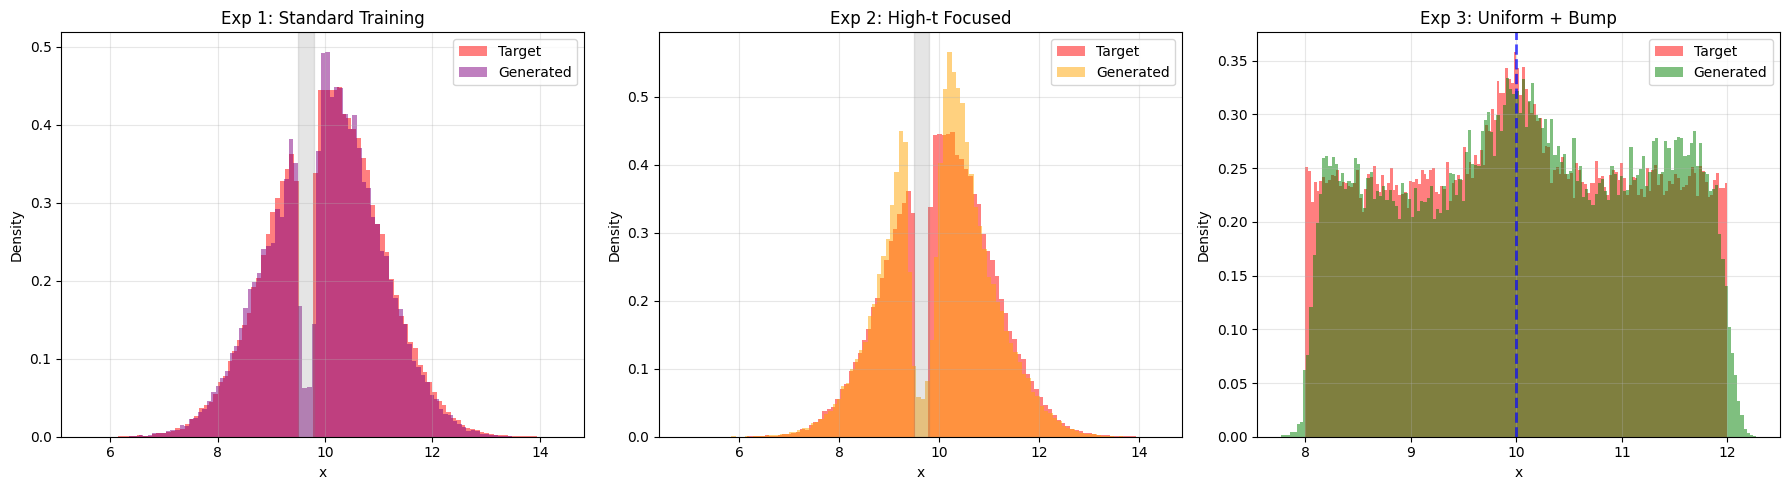

In [ ]:
# Compare final distributions from all experiments
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Experiment 1 with target
axes[0].hist(target_samples.numpy(), bins=100, density=True, alpha=0.5, color='red', label='Target')
axes[0].hist(sol_exp1[-1], bins=100, density=True, alpha=0.5, color='purple', label='Generated')
axes[0].axvspan(gap_start, gap_end, alpha=0.2, color='gray')
axes[0].set_title('Exp 1: Standard Training', fontsize=12)
axes[0].set_xlabel('x')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Experiment 2 with target
axes[1].hist(target_samples.numpy(), bins=100, density=True, alpha=0.5, color='red', label='Target')
axes[1].hist(sol_exp2[-1], bins=100, density=True, alpha=0.5, color='orange', label='Generated')
axes[1].axvspan(gap_start, gap_end, alpha=0.2, color='gray')
axes[1].set_title('Exp 2: High-t Focused', fontsize=12)
axes[1].set_xlabel('x')
axes[1].set_ylabel('Density')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Experiment 3 with target
axes[2].hist(target_samples_exp3.numpy(), bins=150, density=True, alpha=0.5, color='red', label='Target')
axes[2].hist(sol_exp3[-1], bins=150, density=True, alpha=0.5, color='green', label='Generated')
axes[2].axvline(bump_mean, color='blue', linestyle='--', linewidth=2, alpha=0.7)
axes[2].set_title('Exp 3: Uniform + Bump', fontsize=12)
axes[2].set_xlabel('x')
axes[2].set_ylabel('Density')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

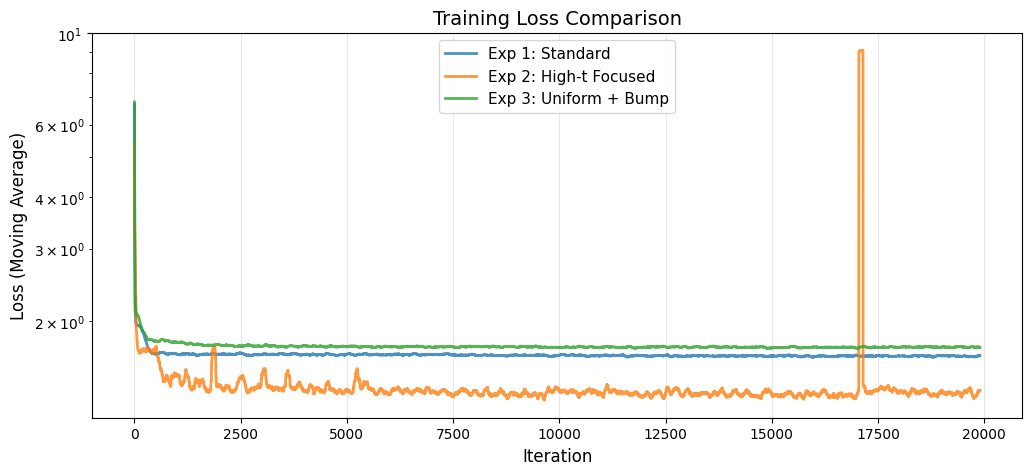

In [ ]:
# Compare training losses
plt.figure(figsize=(12, 5))
plt.plot(np.convolve(losses_exp1, np.ones(100)/100, mode='valid'), linewidth=2, label='Exp 1: Standard', alpha=0.8)
plt.plot(np.convolve(losses_exp2, np.ones(100)/100, mode='valid'), linewidth=2, label='Exp 2: High-t Focused', alpha=0.8)
plt.plot(np.convolve(losses_exp3, np.ones(100)/100, mode='valid'), linewidth=2, label='Exp 3: Uniform + Bump', alpha=0.8)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss (Moving Average)', fontsize=12)
plt.title('Training Loss Comparison', fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.yscale('log')
plt.show()

In [5]:
realistic_dataset = np.load("data.npy")
dphi = realistic_dataset[:, 6]  # Assuming 7th column is the target variable

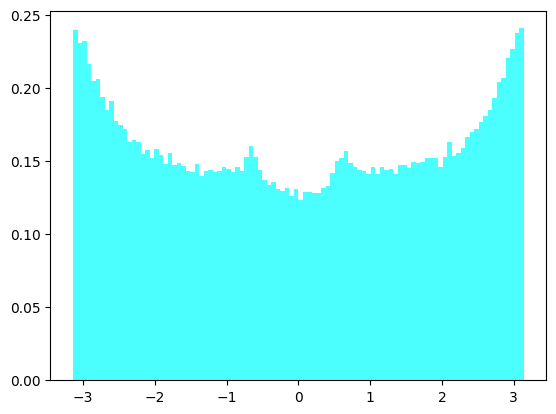

In [6]:
plt.hist(dphi, bins=100, density=True, alpha=0.7, color='cyan')
plt.show()

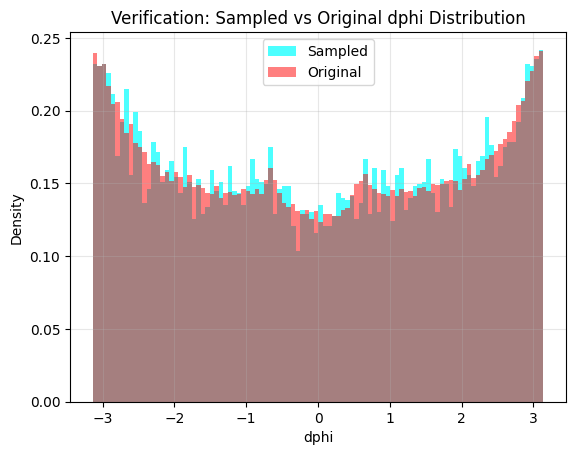

In [8]:
# Create a custom sampler for dphi distribution
dphi_tensor = torch.from_numpy(dphi).float()

def sample_dphi(n_samples):
    """Sample from dphi distribution by randomly selecting from the dataset"""
    indices = torch.randint(0, len(dphi_tensor), (n_samples,))
    return dphi_tensor[indices]

# Test sampling
test_samples = sample_dphi(10000)
plt.hist(test_samples.numpy(), bins=100, density=True, alpha=0.7, color='cyan', label='Sampled')
plt.hist(dphi, bins=100, density=True, alpha=0.5, color='red', label='Original')
plt.title('Verification: Sampled vs Original dphi Distribution', fontsize=12)
plt.xlabel('dphi')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [24]:
# Initialize new model for dphi
device = 'cuda'
vf4 = MLP(input_dim=1, time_dim=1, hidden_dim=128, num_layers=6).to(device)
optim4 = torch.optim.Adam(vf4.parameters(), lr=lr)
# print model parameters count
total_params = sum(p.numel() for p in vf4.parameters())
print(f"Experiment 4 Model Parameters: {total_params}")
# start distribution: uniform -3, 3
source_dist = torch.distributions.Uniform(-3.0, 3.0)

# Training loop
losses_exp4 = []
start_time = time.time()
epochs = 1001
bs = 20480
print_every = 20
# Create a DataLoader over the full dataset and iterate in batches
dataset = torch.utils.data.TensorDataset(dphi_tensor.unsqueeze(1))
loader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)


for epoch in range(epochs):
    for batch in loader:
        optim4.zero_grad()
        
        # Batch from dataset
        x_1 = batch[0].to(device)  # shape (batch_curr, 1)
        batch_curr = x_1.size(0)
        
        # Start samples and times sized to current batch
        x_0 = source_dist.sample((batch_curr,)).unsqueeze(1).to(device)
        t = torch.rand(batch_curr).to(device)
        
        # Sample probability path
        path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
        out = vf4(path_sample.x_t, path_sample.t)
        
        # Flow matching loss
        loss = torch.pow(out - path_sample.dx_t, 2).mean()
        
        # Optimizer step
        loss.backward()
        optim4.step()
        
        losses_exp4.append(loss.item())

        
        # Log progress
    if (epoch) % print_every == 0:
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f}'.format(
            epoch, elapsed * 1000 / print_every, loss.item()))
        start_time = time.time()
        


print("\nExperiment 4 training complete!")

Experiment 4 Model Parameters: 66563
| iter      0 | 52.73 ms/step | loss    6.396
| iter     20 | 1072.20 ms/step | loss    5.162
| iter     40 | 1042.54 ms/step | loss    5.080
| iter     60 | 1067.16 ms/step | loss    5.010
| iter     80 | 1044.04 ms/step | loss    4.965
| iter    100 | 1056.92 ms/step | loss    5.008
| iter    120 | 1044.53 ms/step | loss    4.975
| iter    140 | 1061.07 ms/step | loss    4.930
| iter    160 | 1042.23 ms/step | loss    5.069
| iter    180 | 1057.37 ms/step | loss    5.012
| iter    200 | 1033.06 ms/step | loss    5.029


KeyboardInterrupt: 

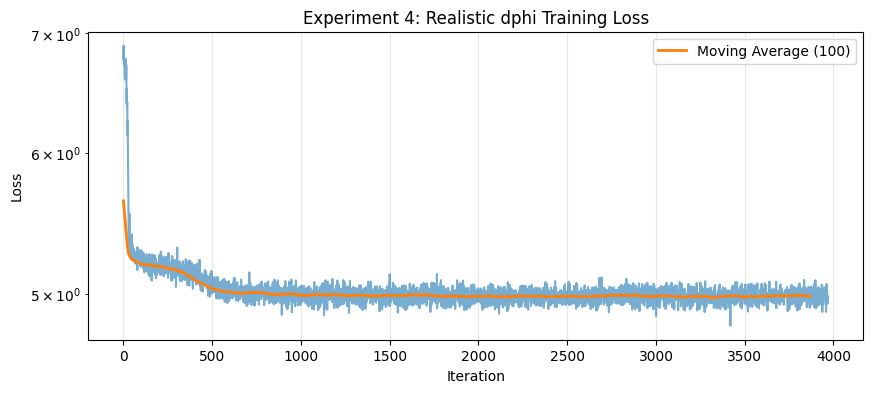

In [25]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses_exp4, alpha=0.6)
plt.plot(np.convolve(losses_exp4, np.ones(100)/100, mode='valid'), linewidth=2, label='Moving Average (100)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Experiment 4: Realistic dphi Training Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.yscale('log')
plt.show()

### Generate Samples and Visualize Trajectories (Experiment 4)

In [26]:
# Sample trajectories
wrapped_vf4 = WrappedModel(vf4)
solver4 = ODESolver(velocity_model=wrapped_vf4)
T = torch.linspace(0, 1, 100).to(device)
n_samples = 100000
x_init_exp4 = source_dist.sample((n_samples,)).unsqueeze(1).to(device)
sol_exp4 = solver4.sample(
    time_grid=T, 
    x_init=x_init_exp4, 
    method='dopri5', 
    step_size=None, 
    return_intermediates=True
)
sol_exp4 = sol_exp4.cpu().numpy().squeeze()

print(f"Generated trajectories shape: {sol_exp4.shape}")

Generated trajectories shape: (100, 100000)


In [27]:
# save model checkpoint
torch.save(vf4.state_dict(), "experiment_4_dphi_model.pth")

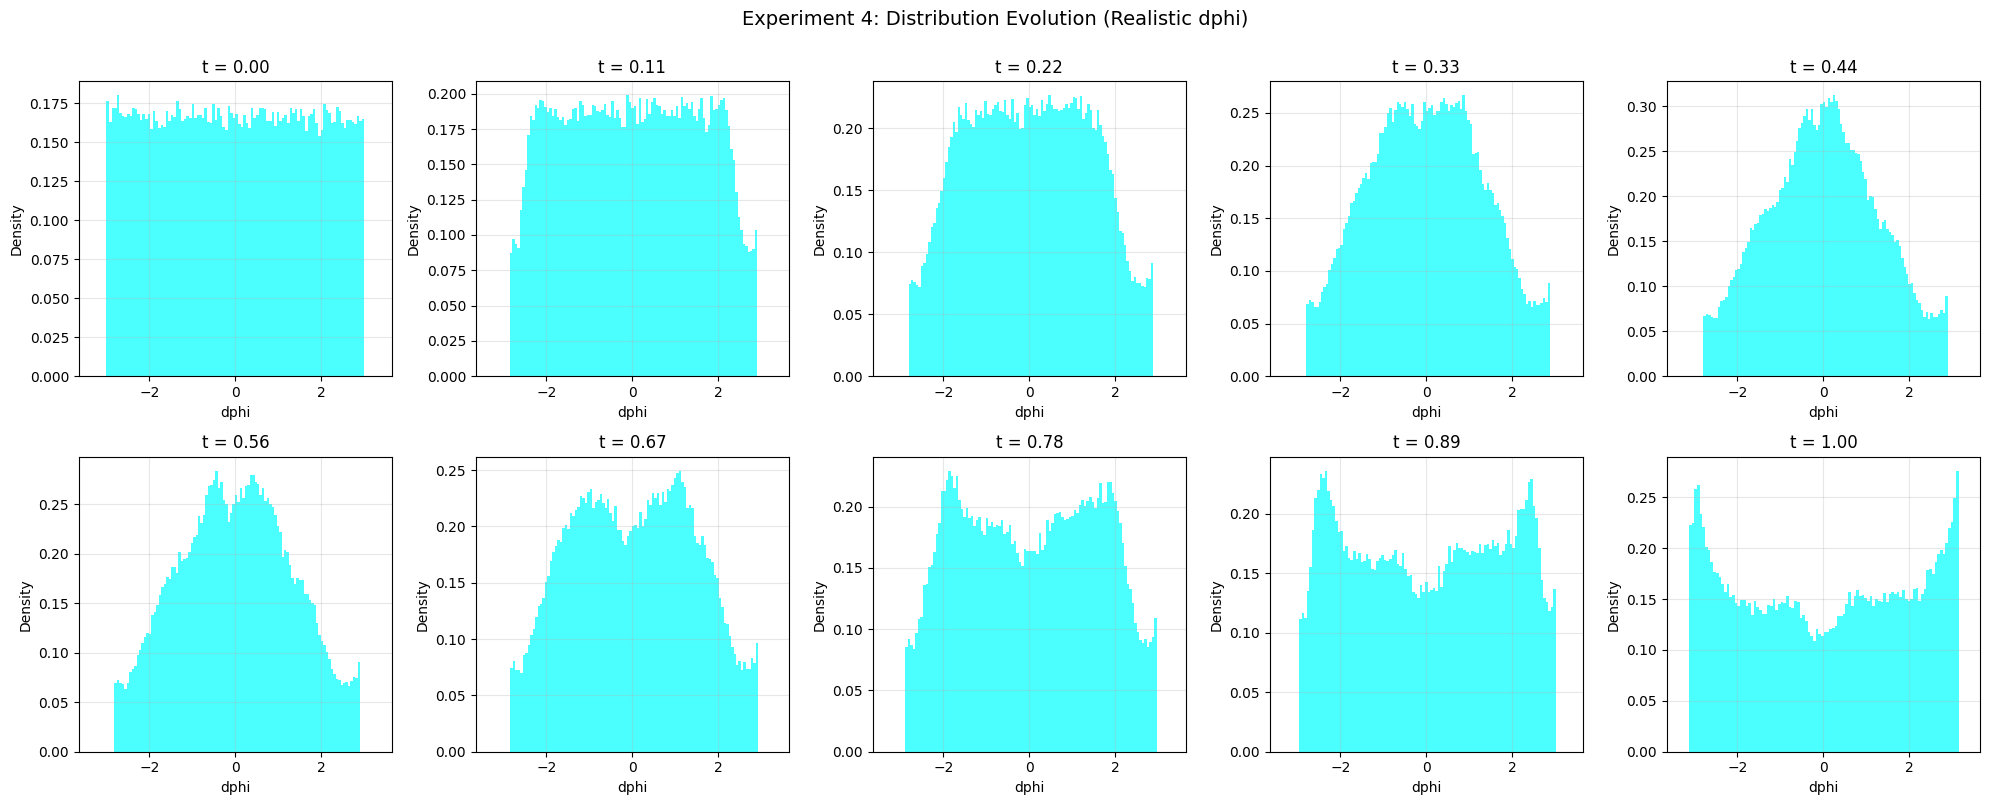

In [28]:
# Visualize evolution over time
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()
time_indices = np.linspace(0, len(T)-1, 10, dtype=int)

for idx, t_idx in enumerate(time_indices):
    axes[idx].hist(sol_exp4[t_idx], bins=100, density=True, alpha=0.7, color='cyan')
    axes[idx].set_title(f't = {T[t_idx].cpu().item():.2f}')
    axes[idx].set_xlabel('dphi')
    axes[idx].set_ylabel('Density')
    axes[idx].grid(alpha=0.3)
    # Set xlim based on data range
    axes[idx].set_xlim(dphi.min() - 0.5, dphi.max() + 0.5)

plt.suptitle('Experiment 4: Distribution Evolution (Realistic dphi)', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

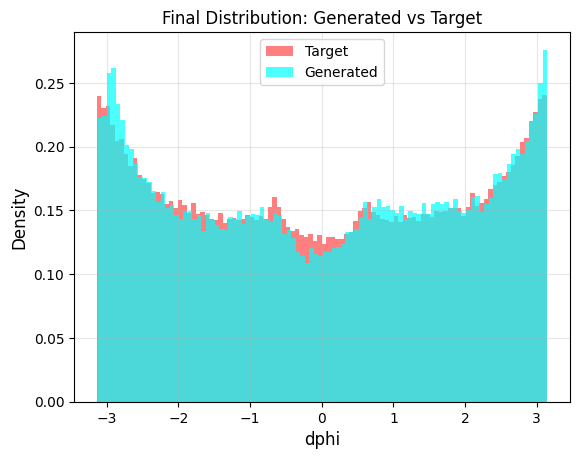

In [29]:
final_positions_exp4 = sol_exp4[-1, :]
plt.hist(dphi, bins=100, density=True, alpha=0.5, color='red', label='Target')
plt.hist(final_positions_exp4, bins=100, density=True, alpha=0.7, color='cyan', label='Generated')
plt.xlabel('dphi', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Final Distribution: Generated vs Target', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# let's draw

In [ ]:
# Visualize individual trajectories
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# n_trajectory_samples = 100000
# Plot sample trajectories
# for i in range(min(n_trajectory_samples, n_samples)):
#     axes[0].plot(T.cpu().numpy(), sol_exp4[:, i], alpha=0.1, color='cyan', linewidth=0.5)

axes[0].set_xlabel('Time (t)', fontsize=12)
axes[0].set_ylabel('dphi', fontsize=12)
axes[0].set_title('Sample Trajectories (Experiment 4)', fontsize=12)
axes[0].grid(alpha=0.3)

# Show distribution of final positions
final_positions_exp4 = sol_exp4[-1, :]
axes[1].hist(dphi, bins=100, density=True, alpha=0.5, color='red', label='Target')
axes[1].hist(final_positions_exp4, bins=100, density=True, alpha=0.7, color='cyan', label='Generated')
axes[1].set_xlabel('dphi', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].set_title('Final Distribution: Generated vs Target', fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [ ]:
# Detailed comparison with statistical tests
from scipy import stats

# Compute Wasserstein distance (Earth Mover's Distance)
wasserstein_dist = stats.wasserstein_distance(dphi, final_positions_exp4)

# Compute Kolmogorov-Smirnov statistic
ks_statistic, ks_pvalue = stats.ks_2samp(dphi, final_positions_exp4)

print("Statistical Comparison:")
print(f"  Wasserstein Distance: {wasserstein_dist:.6f}")
print(f"  KS Statistic: {ks_statistic:.6f}")
print(f"  KS p-value: {ks_pvalue:.6f}")
print("\nDistribution Statistics:")
print(f"  Target - Mean: {dphi.mean():.4f}, Std: {dphi.std():.4f}")
print(f"  Generated - Mean: {final_positions_exp4.mean():.4f}, Std: {final_positions_exp4.std():.4f}")

Statistical Comparison:
  Wasserstein Distance: 0.069178
  KS Statistic: 0.017414
  KS p-value: 0.000000

Distribution Statistics:
  Target - Mean: -0.0027, Std: 1.9399
  Generated - Mean: 0.0649, Std: 1.9279


## Experiment 5: dphi with High-t Focused Training

Same as Experiment 4 but with oversampling of t > 0.75 to better capture the target distribution structure.

In [19]:
# Initialize new model
vf5 = MLP(input_dim=1, time_dim=1, hidden_dim=hidden_dim).to(device)
optim5 = torch.optim.Adam(vf5.parameters(), lr=lr)

# Training loop with biased time sampling
losses_exp5 = []
start_time = time.time()
high_t_oversample_ratio = 3
for i in range(iterations):
    optim5.zero_grad()
    
    # Sample data
    x_1 = sample_dphi(batch_size).unsqueeze(1).to(device)
    x_0 = source_dist.sample((batch_size,)).unsqueeze(1).to(device)
    
    # Biased time sampling: oversample t > 0.75
    if np.random.rand() < high_t_oversample_ratio / (1 + high_t_oversample_ratio):
        # Sample from [0.9, 1.0]
        t = torch.rand(batch_size).to(device) * 0.1 + 0.9
    else:
        # Sample uniformly from [0, 1]
        t = torch.rand(batch_size).to(device)
    
    # Sample probability path
    path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
    out = vf5(path_sample.x_t, path_sample.t)
    
    # Flow matching loss
    loss = torch.pow(out - path_sample.dx_t, 2).mean()
    
    # Optimizer step
    loss.backward()
    optim5.step()
    
    losses_exp5.append(loss.item())
    
    # Log progress
    if (i + 1) % print_every == 0:
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f}'.format(
            i + 1, elapsed * 1000 / print_every, loss.item()))
        start_time = time.time()

print("\nExperiment 5 training complete!")

| iter   2000 |  4.85 ms/step | loss    3.282
| iter   4000 |  4.82 ms/step | loss    3.295
| iter   6000 |  4.82 ms/step | loss    5.055
| iter   8000 |  4.82 ms/step | loss    5.086
| iter  10000 |  4.77 ms/step | loss    3.212
| iter  12000 |  4.75 ms/step | loss    3.221
| iter  14000 |  4.78 ms/step | loss    5.042
| iter  16000 |  4.74 ms/step | loss    3.192
| iter  18000 |  4.74 ms/step | loss    3.174
| iter  20000 |  4.78 ms/step | loss    3.159

Experiment 5 training complete!


In [20]:
# Generate samples
wrapped_vf5 = WrappedModel(vf5)
solver5 = ODESolver(velocity_model=wrapped_vf5)

x_init_exp5 = source_dist.sample((n_samples,)).unsqueeze(1).to(device)
sol_exp5 = solver5.sample(
    time_grid=T, 
    x_init=x_init_exp5, 
    method='dopri5', 
    step_size=None, 
    return_intermediates=True
)
sol_exp5 = sol_exp5.cpu().numpy().squeeze()
final_positions_exp5 = sol_exp5[-1, :]

print(f"Generated trajectories shape: {sol_exp5.shape}")

Generated trajectories shape: (100, 100000)


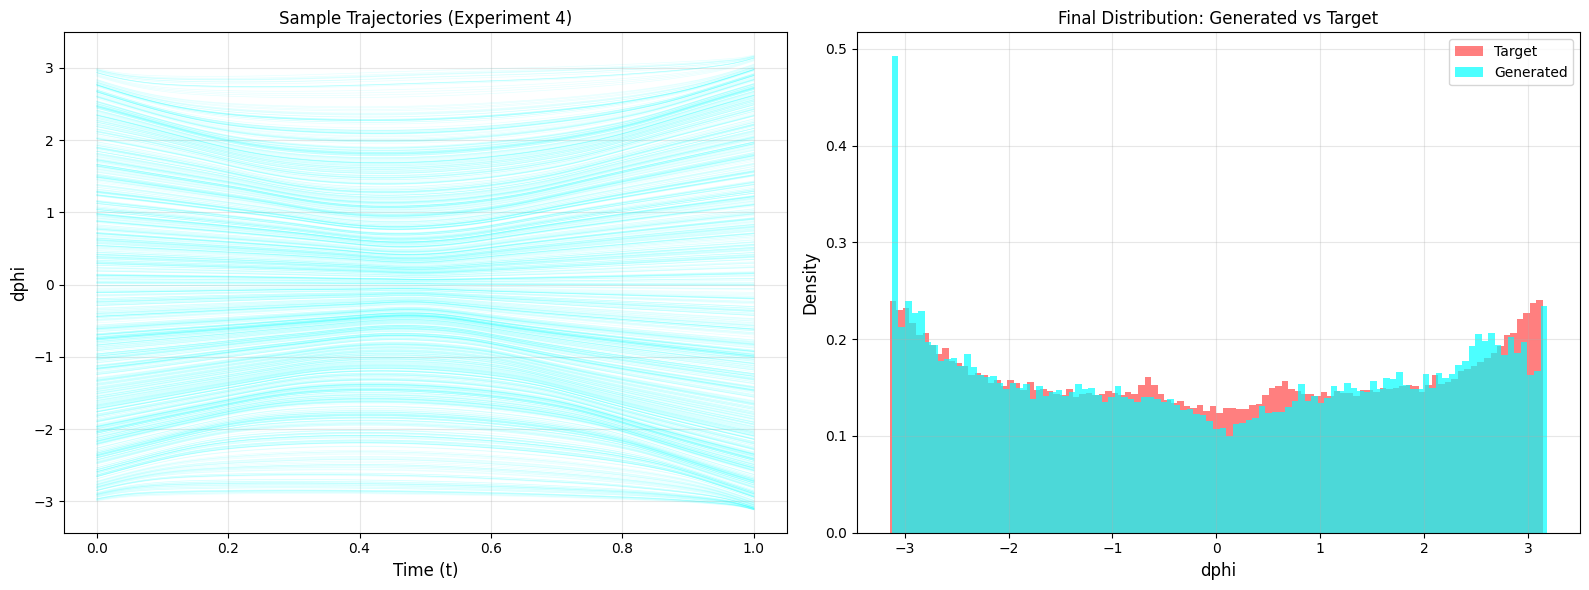

In [23]:
# plot trajectories of sol_exp5
# Visualize individual trajectories
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
n_trajectory_samples = 1000
# Plot sample trajectories
for i in range(min(n_trajectory_samples, n_samples)):
    axes[0].plot(T.cpu().numpy(), sol_exp5[:, i], alpha=0.1, color='cyan', linewidth=0.5)

axes[0].set_xlabel('Time (t)', fontsize=12)
axes[0].set_ylabel('dphi', fontsize=12)
axes[0].set_title('Sample Trajectories (Experiment 4)', fontsize=12)
axes[0].grid(alpha=0.3)


axes[1].hist(dphi, bins=100, density=True, alpha=0.5, color='red', label='Target')
axes[1].hist(final_positions_exp5, bins=100, density=True, alpha=0.7, color='cyan', label='Generated')
axes[1].set_xlabel('dphi', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].set_title('Final Distribution: Generated vs Target', fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Experiment 6: dphi with HUGE Neural Network

Using a much larger network (2048 hidden units instead of 512) to see if model capacity improves the fit.

In [24]:
# Initialize HUGE model
huge_hidden_dim = 2048
vf6 = MLP(input_dim=1, time_dim=1, hidden_dim=huge_hidden_dim).to(device)
optim6 = torch.optim.Adam(vf6.parameters(), lr=lr)

print(f"Model size comparison:")
print(f"  Standard model (exp 4 & 5): {sum(p.numel() for p in vf4.parameters()):,} parameters")
print(f"  HUGE model (exp 6): {sum(p.numel() for p in vf6.parameters()):,} parameters")

# Training loop
losses_exp6 = []
start_time = time.time()

for i in range(iterations):
    optim6.zero_grad()
    
    # Sample data
    x_1 = sample_dphi(batch_size).unsqueeze(1).to(device)
    x_0 = source_dist.sample((batch_size,)).unsqueeze(1).to(device)
    
    # Sample time uniformly
    t = torch.rand(batch_size).to(device)
    
    # Sample probability path
    path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
    out = vf6(path_sample.x_t, path_sample.t)
    
    # Flow matching loss
    loss = torch.pow(out - path_sample.dx_t, 2).mean()
    
    # Optimizer step
    loss.backward()
    optim6.step()
    
    losses_exp6.append(loss.item())
    
    # Log progress
    if (i + 1) % print_every == 0:
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f}'.format(
            i + 1, elapsed * 1000 / print_every, loss.item()))
        start_time = time.time()

print("\nExperiment 6 training complete!")

Model size comparison:
  Standard model (exp 4 & 5): 50,051 parameters
  HUGE model (exp 6): 12,597,251 parameters
| iter   2000 | 46.62 ms/step | loss    5.067
| iter   4000 | 46.50 ms/step | loss    4.865
| iter   6000 | 46.53 ms/step | loss    4.941
| iter   8000 | 46.54 ms/step | loss    4.948
| iter  10000 | 46.81 ms/step | loss    4.907
| iter  12000 | 47.47 ms/step | loss    4.992
| iter  14000 | 50.54 ms/step | loss    5.036
| iter  16000 | 62.46 ms/step | loss    4.959
| iter  18000 | 49.78 ms/step | loss    5.140
| iter  20000 | 47.49 ms/step | loss    4.875

Experiment 6 training complete!


In [26]:
# Generate samples
wrapped_vf6 = WrappedModel(vf6)
solver6 = ODESolver(velocity_model=wrapped_vf6)

x_init_exp6 = source_dist.sample((n_samples,)).unsqueeze(1).to(device)
sol_exp6 = solver6.sample(
    time_grid=T, 
    x_init=x_init_exp6, 
    method='dopri5', 
    step_size=None, 
    return_intermediates=True
)
sol_exp6 = sol_exp6.cpu().numpy().squeeze()
final_positions_exp6 = sol_exp6[-1, :]

print(f"Generated trajectories shape: {sol_exp6.shape}")

Generated trajectories shape: (100, 100000)


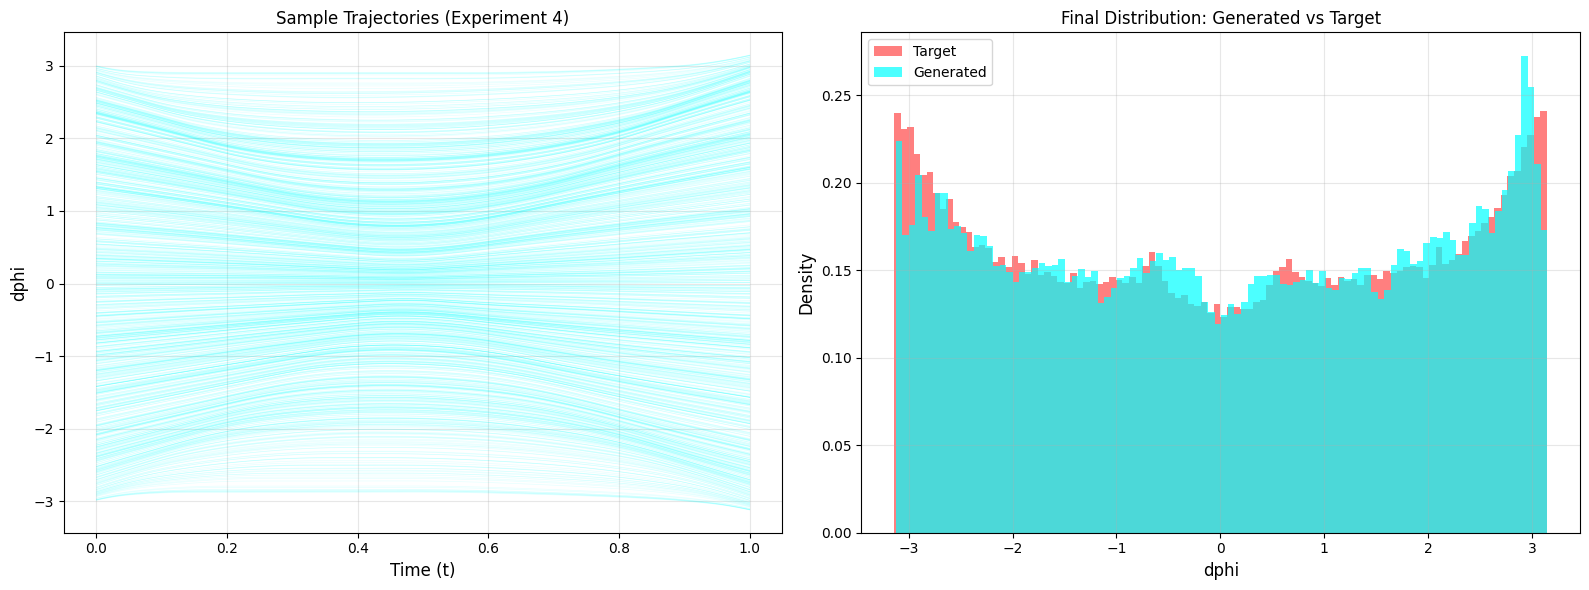

In [27]:
# Visualize individual trajectories
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
n_trajectory_samples = 1000
# Plot sample trajectories
for i in range(min(n_trajectory_samples, n_samples)):
    axes[0].plot(T.cpu().numpy(), sol_exp6[:, i], alpha=0.1, color='cyan', linewidth=0.5)

axes[0].set_xlabel('Time (t)', fontsize=12)
axes[0].set_ylabel('dphi', fontsize=12)
axes[0].set_title('Sample Trajectories (Experiment 4)', fontsize=12)
axes[0].grid(alpha=0.3)


axes[1].hist(dphi, bins=100, density=True, alpha=0.5, color='red', label='Target')
axes[1].hist(final_positions_exp6, bins=100, density=True, alpha=0.7, color='cyan', label='Generated')
axes[1].set_xlabel('dphi', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].set_title('Final Distribution: Generated vs Target', fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Comparison: dphi Experiments (Standard, High-t, HUGE NN)

Comparing the three dphi experiments using Wasserstein distance and visualizations.

In [ ]:
# Compute Wasserstein distances for all three dphi experiments
ws_exp4 = stats.wasserstein_distance(dphi, final_positions_exp4)
ws_exp5 = stats.wasserstein_distance(dphi, final_positions_exp5)
ws_exp6 = stats.wasserstein_distance(dphi, final_positions_exp6)

# Compute KS statistics
ks_exp4, ks_pval4 = stats.ks_2samp(dphi, final_positions_exp4)
ks_exp5, ks_pval5 = stats.ks_2samp(dphi, final_positions_exp5)
ks_exp6, ks_pval6 = stats.ks_2samp(dphi, final_positions_exp6)

print("=" * 70)
print("WASSERSTEIN DISTANCE COMPARISON (lower is better)")
print("=" * 70)
print(f"Experiment 4 (Standard):       {ws_exp4:.6f}")
print(f"Experiment 5 (High-t Focused): {ws_exp5:.6f}")
print(f"Experiment 6 (HUGE NN):        {ws_exp6:.6f}")
print()
print("Improvement vs Standard:")
print(f"  High-t Focused: {((ws_exp4 - ws_exp5) / ws_exp4 * 100):+.2f}%")
print(f"  HUGE NN:        {((ws_exp4 - ws_exp6) / ws_exp4 * 100):+.2f}%")
print()
print("=" * 70)
print("KOLMOGOROV-SMIRNOV STATISTIC (lower is better)")
print("=" * 70)
print(f"Experiment 4: {ks_exp4:.6f} (p-value: {ks_pval4:.6f})")
print(f"Experiment 5: {ks_exp5:.6f} (p-value: {ks_pval5:.6f})")
print(f"Experiment 6: {ks_exp6:.6f} (p-value: {ks_pval6:.6f})")
print()
print("=" * 70)
print("DISTRIBUTION STATISTICS")
print("=" * 70)
print(f"Target:       Mean={dphi.mean():.4f}, Std={dphi.std():.4f}")
print(f"Experiment 4: Mean={final_positions_exp4.mean():.4f}, Std={final_positions_exp4.std():.4f}")
print(f"Experiment 5: Mean={final_positions_exp5.mean():.4f}, Std={final_positions_exp5.std():.4f}")
print(f"Experiment 6: Mean={final_positions_exp6.mean():.4f}, Std={final_positions_exp6.std():.4f}")

WASSERSTEIN DISTANCE COMPARISON (lower is better)
Experiment 4 (Standard):       0.069178
Experiment 5 (High-t Focused): 0.069724
Experiment 6 (HUGE NN):        0.069606

Improvement vs Standard:
  High-t Focused: -0.79%
  HUGE NN:        -0.62%

KOLMOGOROV-SMIRNOV STATISTIC (lower is better)
Experiment 4: 0.017414 (p-value: 0.000000)
Experiment 5: 0.023722 (p-value: 0.000000)
Experiment 6: 0.024409 (p-value: 0.000000)

DISTRIBUTION STATISTICS
Target:       Mean=-0.0027, Std=1.9399
Experiment 4: Mean=0.0649, Std=1.9279
Experiment 5: Mean=-0.0361, Std=1.8815
Experiment 6: Mean=0.0077, Std=1.8931


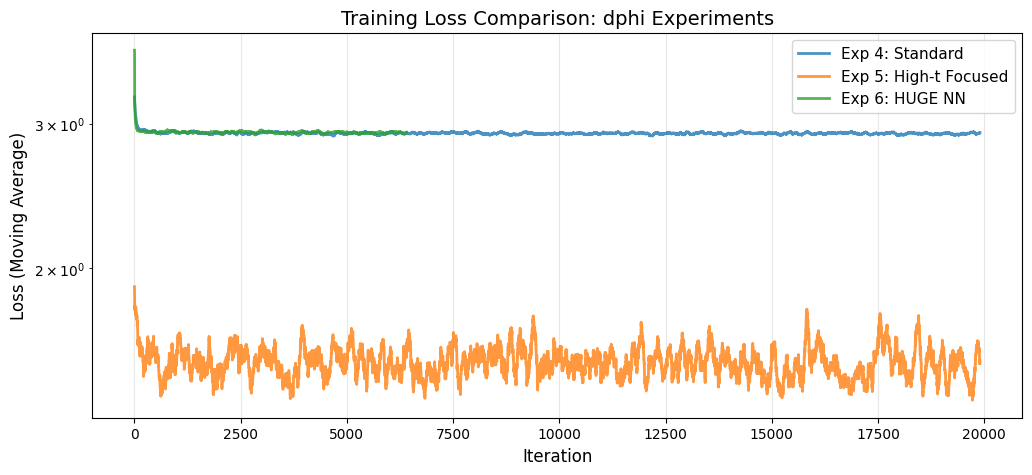

In [ ]:
# Visualize training losses
plt.figure(figsize=(12, 5))
plt.plot(np.convolve(losses_exp4, np.ones(100)/100, mode='valid'), linewidth=2, label='Exp 4: Standard', alpha=0.8)
plt.plot(np.convolve(losses_exp5, np.ones(100)/100, mode='valid'), linewidth=2, label='Exp 5: High-t Focused', alpha=0.8)
plt.plot(np.convolve(losses_exp6, np.ones(100)/100, mode='valid'), linewidth=2, label='Exp 6: HUGE NN', alpha=0.8)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss (Moving Average)', fontsize=12)
plt.title('Training Loss Comparison: dphi Experiments', fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.yscale('log')
plt.show()

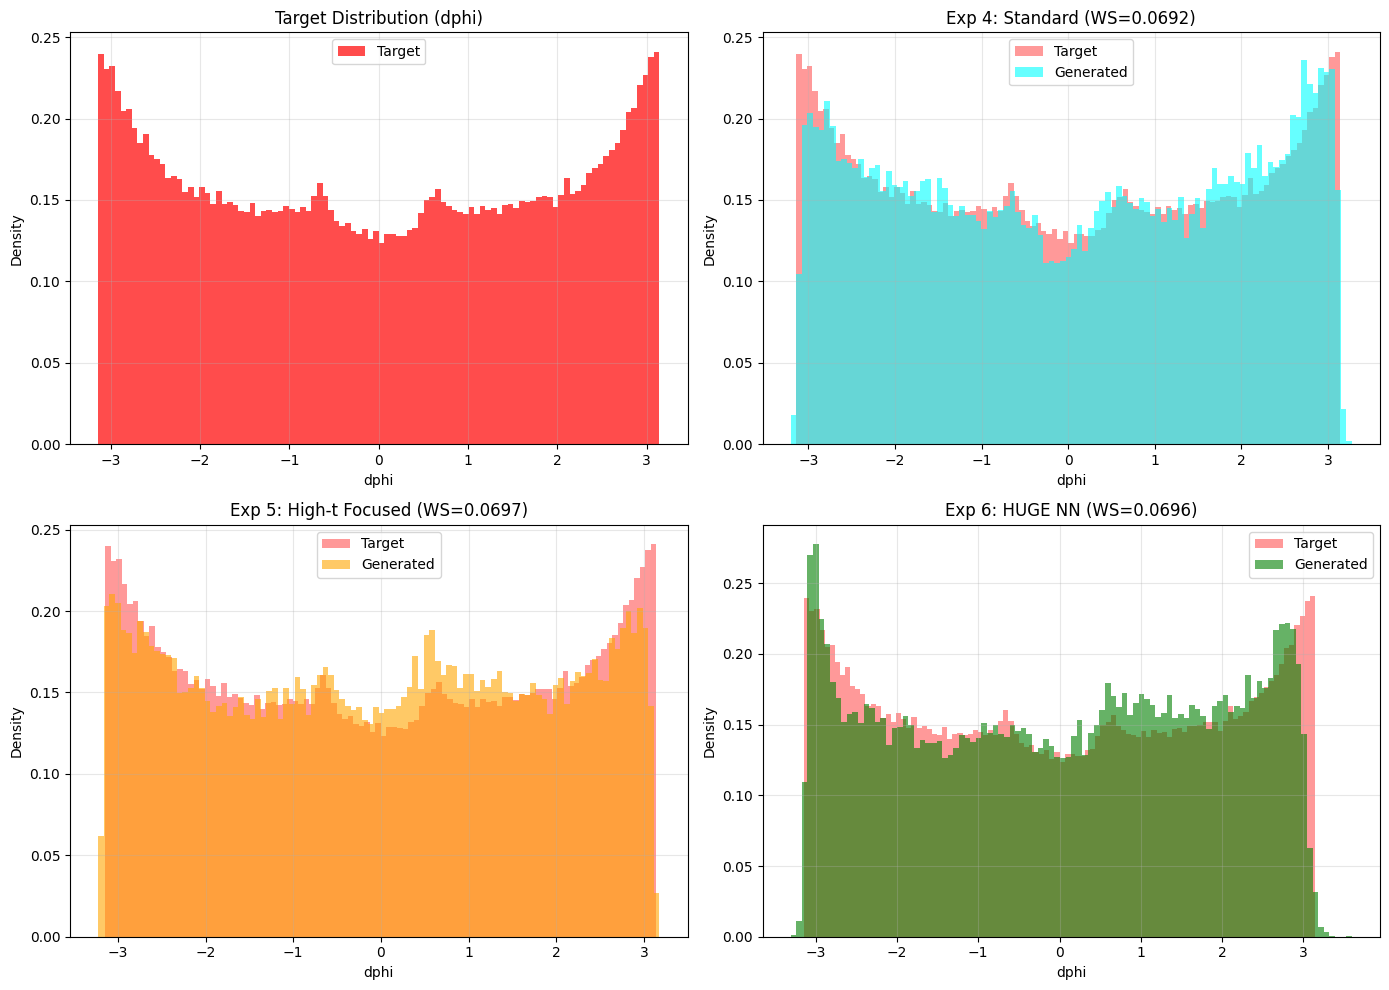

In [ ]:
# Compare final distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Target distribution (for reference in all plots)
axes[0, 0].hist(dphi, bins=100, density=True, alpha=0.7, color='red', label='Target')
axes[0, 0].set_title('Target Distribution (dphi)', fontsize=12)
axes[0, 0].set_xlabel('dphi')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Experiment 4: Standard
axes[0, 1].hist(dphi, bins=100, density=True, alpha=0.4, color='red', label='Target')
axes[0, 1].hist(final_positions_exp4, bins=100, density=True, alpha=0.6, color='cyan', label='Generated')
axes[0, 1].set_title(f'Exp 4: Standard (WS={ws_exp4:.4f})', fontsize=12)
axes[0, 1].set_xlabel('dphi')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Experiment 5: High-t Focused
axes[1, 0].hist(dphi, bins=100, density=True, alpha=0.4, color='red', label='Target')
axes[1, 0].hist(final_positions_exp5, bins=100, density=True, alpha=0.6, color='orange', label='Generated')
axes[1, 0].set_title(f'Exp 5: High-t Focused (WS={ws_exp5:.4f})', fontsize=12)
axes[1, 0].set_xlabel('dphi')
axes[1, 0].set_ylabel('Density')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Experiment 6: HUGE NN
axes[1, 1].hist(dphi, bins=100, density=True, alpha=0.4, color='red', label='Target')
axes[1, 1].hist(final_positions_exp6, bins=100, density=True, alpha=0.6, color='green', label='Generated')
axes[1, 1].set_title(f'Exp 6: HUGE NN (WS={ws_exp6:.4f})', fontsize=12)
axes[1, 1].set_xlabel('dphi')
axes[1, 1].set_ylabel('Density')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

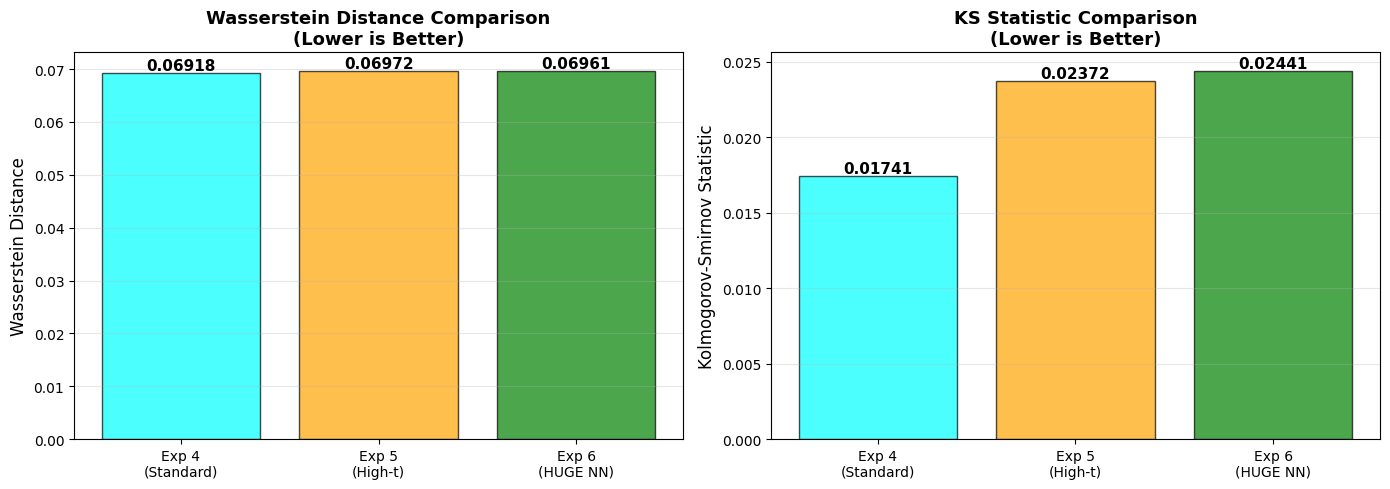


BEST MODEL SUMMARY
Best by Wasserstein Distance: Exp 4 (Standard)
Best by KS Statistic: Exp 4 (Standard)


In [ ]:
# Bar chart comparing Wasserstein distances
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

experiments = ['Exp 4\n(Standard)', 'Exp 5\n(High-t)', 'Exp 6\n(HUGE NN)']
ws_distances = [ws_exp4, ws_exp5, ws_exp6]
ks_statistics = [ks_exp4, ks_exp5, ks_exp6]

colors = ['cyan', 'orange', 'green']

# Wasserstein distance comparison
bars1 = axes[0].bar(experiments, ws_distances, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Wasserstein Distance', fontsize=12)
axes[0].set_title('Wasserstein Distance Comparison\n(Lower is Better)', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars1, ws_distances)):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.5f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# KS statistic comparison
bars2 = axes[1].bar(experiments, ks_statistics, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Kolmogorov-Smirnov Statistic', fontsize=12)
axes[1].set_title('KS Statistic Comparison\n(Lower is Better)', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars2, ks_statistics)):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.5f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Determine best model
best_ws_idx = np.argmin(ws_distances)
best_ks_idx = np.argmin(ks_statistics)
print(f"\n{'='*70}")
print("BEST MODEL SUMMARY")
print(f"{'='*70}")
print(f"Best by Wasserstein Distance: {experiments[best_ws_idx].replace(chr(10), ' ')}")
print(f"Best by KS Statistic: {experiments[best_ks_idx].replace(chr(10), ' ')}")